In [43]:
import sys
import os
import matplotlib.pyplot as plt
import os
import cv2
import pickle

import sys
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew, probplot

In [44]:
with open('sim.pickle', 'rb') as f:
    sim_dict = pickle.load(f)  # 復元

In [45]:
sim_p = sim_dict["tspoint"]
sim_o = sim_dict["orb"]
sim_to = sim_dict["torb"]
sim_s = sim_dict["sift"]
sim_ts = sim_dict["tsift"]
sim_sp = sim_dict["spoint"]

In [46]:
sim_list = [sim_sp, sim_p, sim_o, sim_to, sim_s, sim_ts]
nm_list = ["SuperPoint", "TSuperPoint", "ORB", "TORB", "SIFT", "TSIFT"]

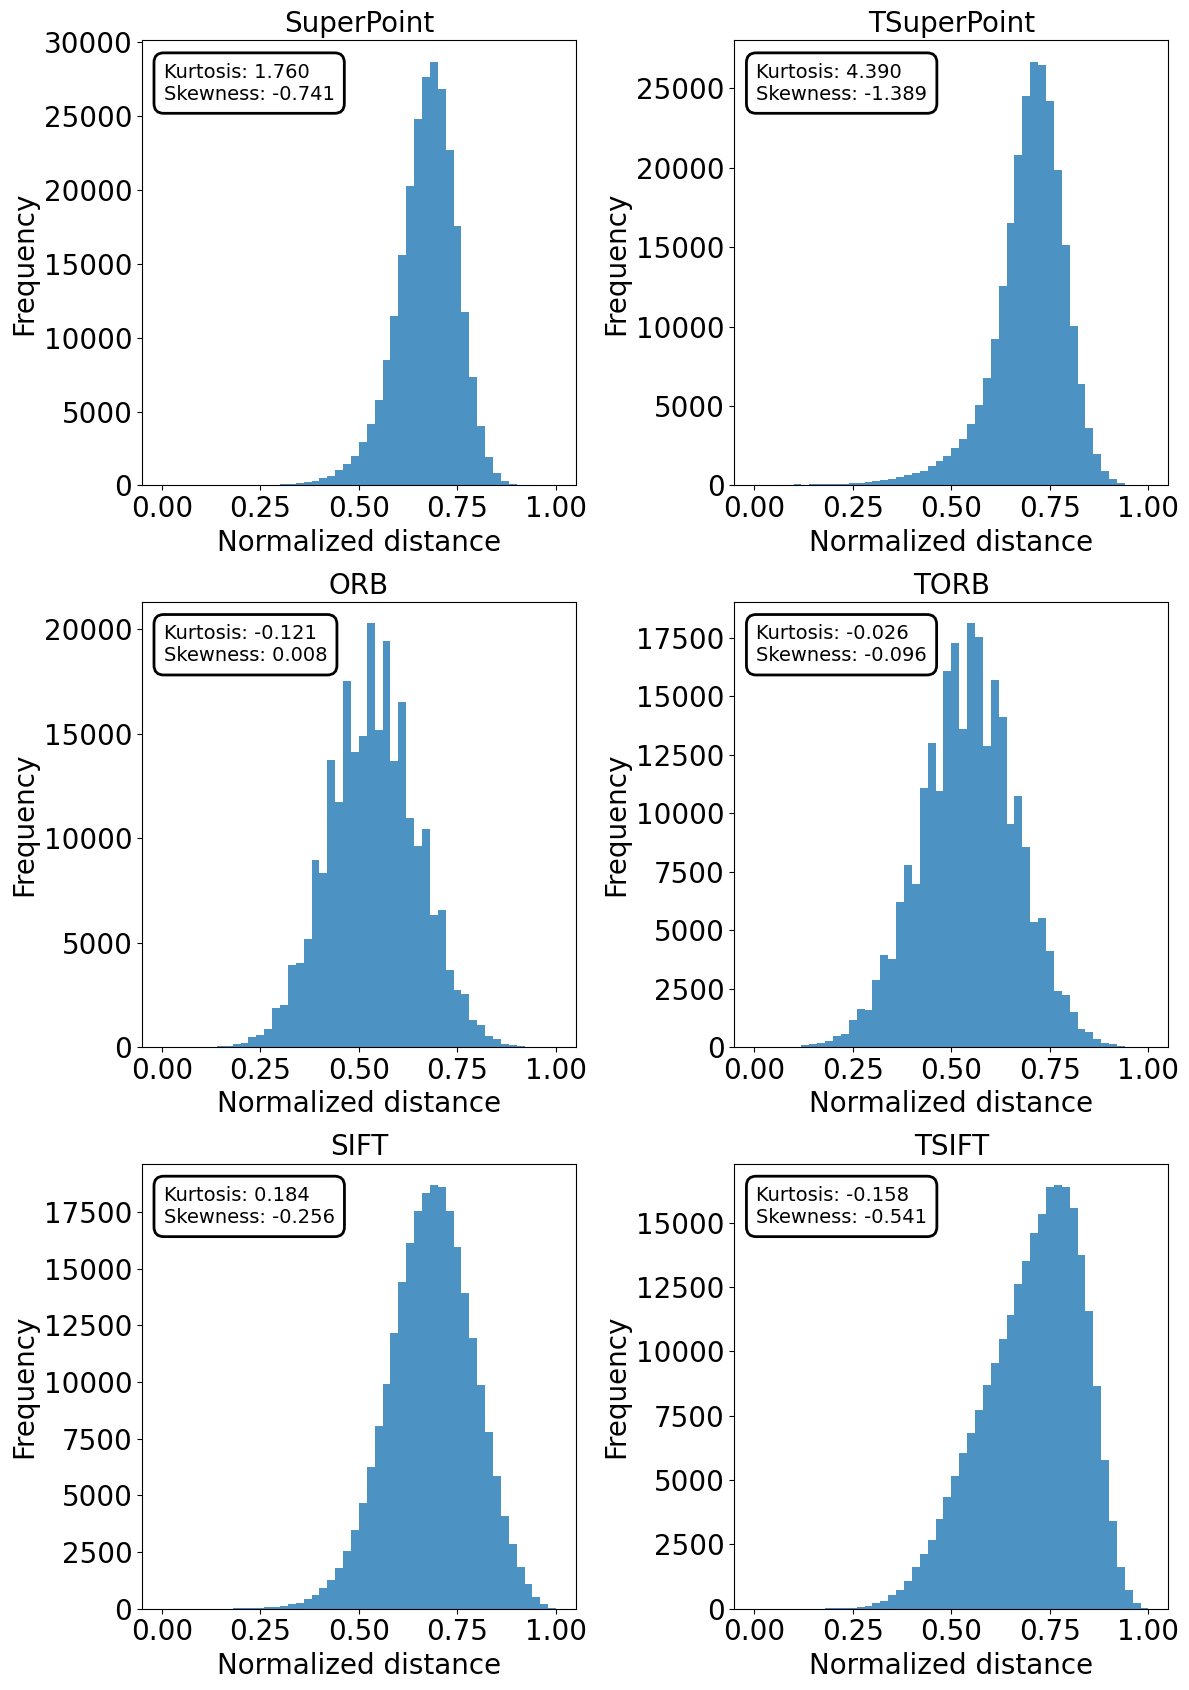

In [62]:
def distplot(sim_list, nm_list):
    fig_img, axs = plt.subplots(3, 2, figsize=(12, 17))
    for idx, sim in enumerate(sim_list):
        ax = axs[idx//2, idx%2]
        flat_sim = sim.flatten().copy()
        flat_sim = -flat_sim
        flat_sim = (flat_sim - np.min(flat_sim)) / (np.max(flat_sim) - np.min(flat_sim))
        kurt = kurtosis(flat_sim)
        sk = skew(flat_sim)
        ax.set_title(f"{nm_list[idx]}", fontsize=20)
        ax.hist(flat_sim, bins=50, label=f"kurt:{kurt:.3f}, skew:{sk:.3f}", alpha=0.8)
        bbox_props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', linewidth=2)
        ax.text(x=0.05, y=0.95, s=f'Kurtosis: {kurt:.3f}\nSkewness: {sk:.3f}', fontsize=14,
                horizontalalignment='left', verticalalignment='top', 
                transform=ax.transAxes, bbox=bbox_props)
        ax.tick_params(axis='both', labelsize=20)
        ax.set_ylabel('Frequency', fontsize=20)
        ax.set_xlabel('Normalized distance', fontsize=20)
    plt.tight_layout()
    plt.show()
distplot(sim_list, nm_list)

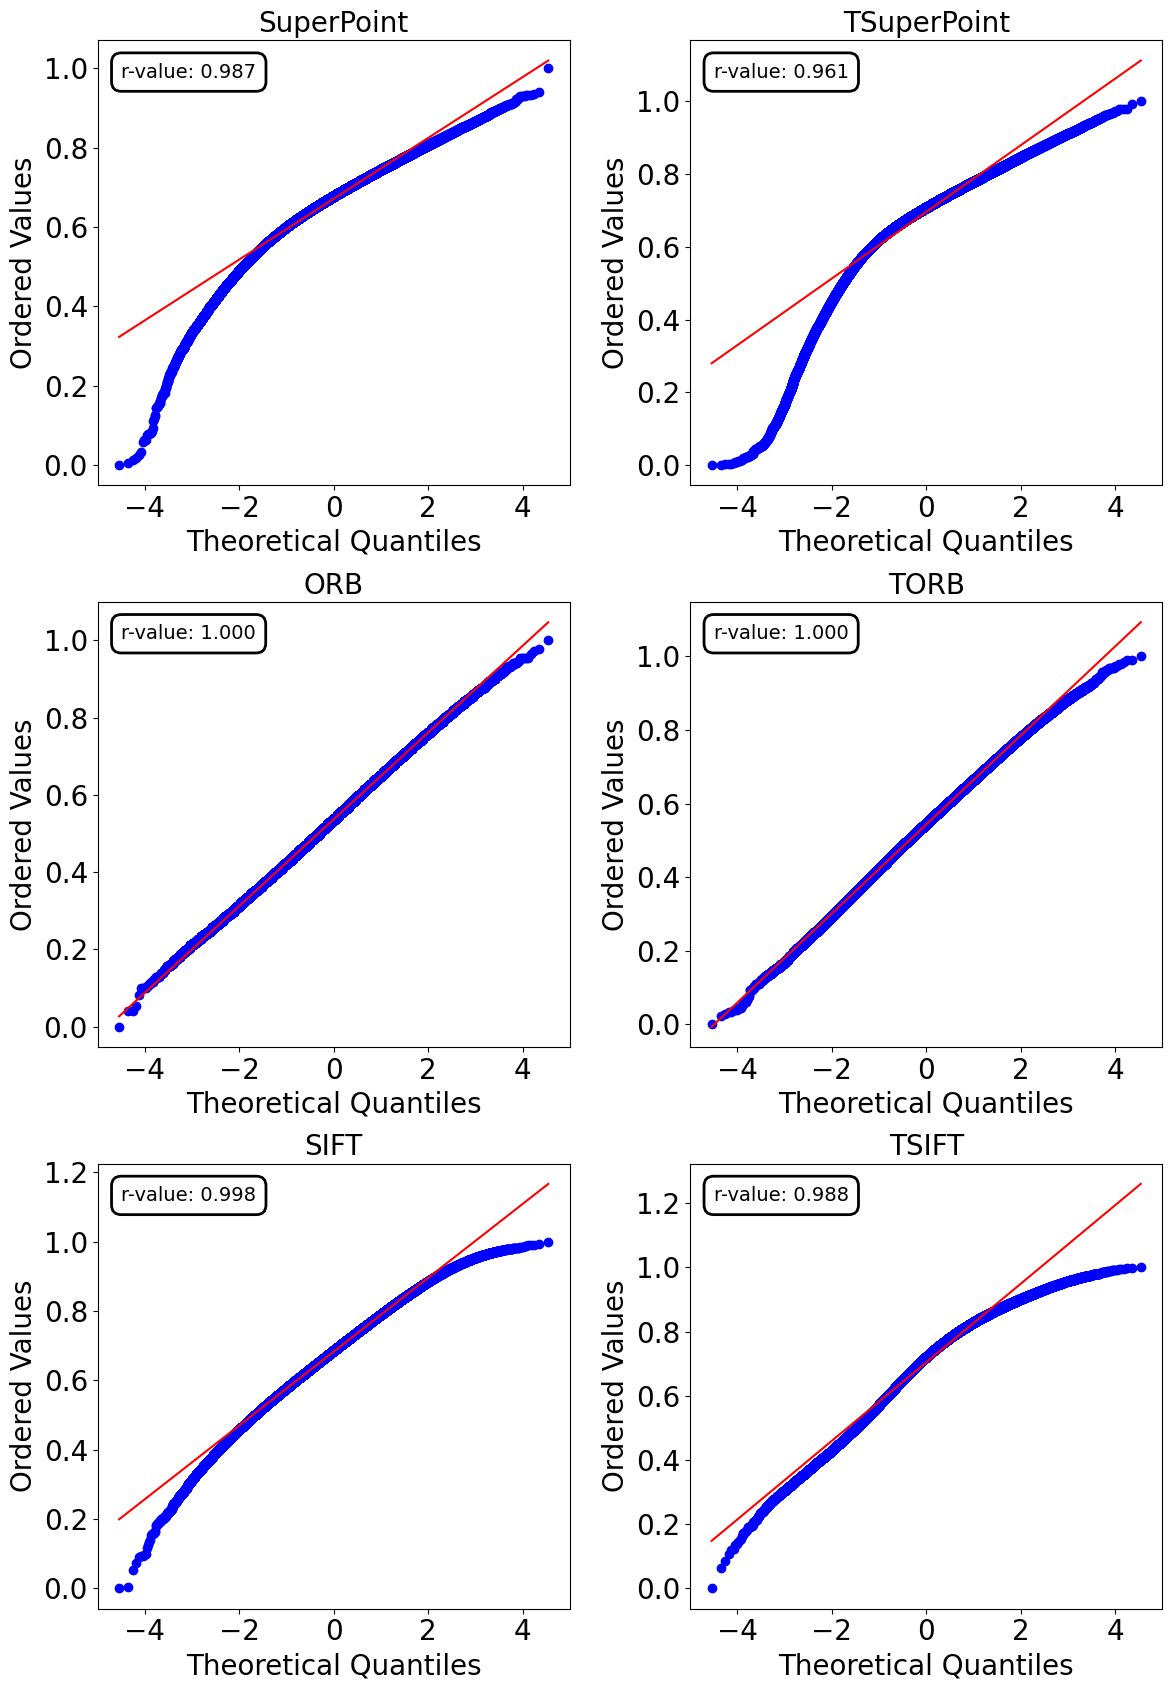

In [61]:
def QQplot(sim_list, nm_list):
    fig_img, axs = plt.subplots(3, 2, figsize=(12, 17))
    for idx, sim in enumerate(sim_list):
        ax = axs[idx//2, idx%2]
        flat_sim = sim.flatten().copy()
        flat_sim = -flat_sim
        flat_sim = (flat_sim - np.min(flat_sim)) / (np.max(flat_sim) - np.min(flat_sim))

        # Q-Qプロットの作成
        (osm, osr), (slope, intercept, r) = probplot(flat_sim, dist="norm", plot=ax)
        bbox_props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', linewidth=2)
        ax.text(x=0.05, y=0.95, s=f'r-value: {r:.3f}', fontsize=14,
                horizontalalignment='left', verticalalignment='top', 
                transform=ax.transAxes, bbox=bbox_props)

        ax.set_title(f"{nm_list[idx]}", fontsize=20)
        ax.tick_params(axis='both', labelsize=20)
        ax.set_ylabel('Ordered Values', fontsize=20)
        ax.set_xlabel('Theoretical Quantiles', fontsize=20)

    plt.tight_layout()
    plt.show()

QQplot(sim_list, nm_list)